In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

We consider missiles with only 1 stage

In [6]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 7000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [7]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

## 2. Maximize range

The central idea of the acquisition function is to trade off the exploration of regions where the model is uncertain and the exploitation of the model’s confidence about good areas of the input space. There are a variety of acquisition functions in Emukit. In this example the expected improvement [3], that computes in expectation how much we can improve with respect to the current best observed location.

Bayesian optimization iterates the following three steps until it achieves a predefined stopping criterion (normally using a fixed number of evaluations).

1. Find the next point to evaluate the objective by using a numerical solver to optimize the acquisition/utility.
2. Evaluate the objective in that location and add the new observation to the data set.
3. Update the model using the currently available data.


In [8]:
m3_param_1 = 'fuelmass'
m3_param_2 = 'Isp0'
m3_param_3 = 'drymass'
m3_param_4 = 'thrust0'
# m3_param_5 = 'payload'
# m3_param_6 = 'missilediam'
# I am not sure 'estrange' and 'rvdiam' can be changed freely

m3_domain_param_1 = basic_param_spaces[m3_param_1] # [500, 6000] # [5000,15000]
m3_domain_param_2 = basic_param_spaces[m3_param_2] # [200, 300] # [224, 228]
m3_domain_param_3 = basic_param_spaces[m3_param_3] 
m3_domain_param_4 = basic_param_spaces[m3_param_4] 
# m3_domain_param_5 = basic_param_spaces[m3_param_5] 
# m3_domain_param_6 = basic_param_spaces[m3_param_6] 


m3_space = ParameterSpace(
          [ContinuousParameter(m3_param_1, *m3_domain_param_1), 
           ContinuousParameter(m3_param_2, *m3_domain_param_2),
           ContinuousParameter(m3_param_3, *m3_domain_param_3), 
           ContinuousParameter(m3_param_4, *m3_domain_param_4),
#            ContinuousParameter(m3_param_5, *m3_domain_param_5), 
#            ContinuousParameter(m3_param_6, *m3_domain_param_6),
          ])
custom_param_names = [m3_param_1, m3_param_2, m3_param_3, m3_param_4, 
#                       m3_param_5, m3_param_6
                     ]
nr_custom_params = len(custom_param_names)

In [9]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y



In [10]:
# To find the maximum of run_missile_sim, we will find the minimum of neg_run_missile_sim
def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)




New simulation 

fuelmass: 677.3340951128262
Isp0: 427.4280520580689
drymass: 1611.4550939422647
thrust0: 23451.7384509065


Stage 1 burnout
Velocity (km/s):  0.9617739208902156
Angle (deg h):  43.89295016664562
Range (km):  2.1579727512592566
Time (sec):  12.399999999999974
Final results: 
Range (km):  102.39789887866972
Apogee (km):  28.185150333108908
Time to target (sec):  157.79999999999532




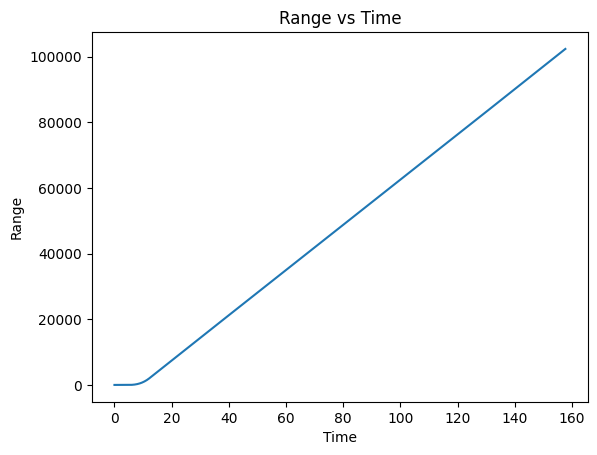

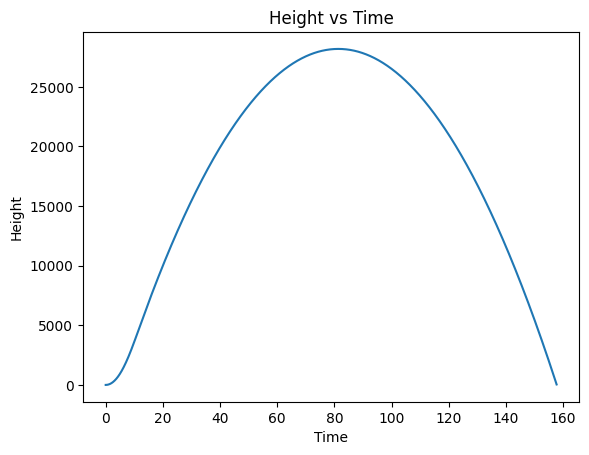

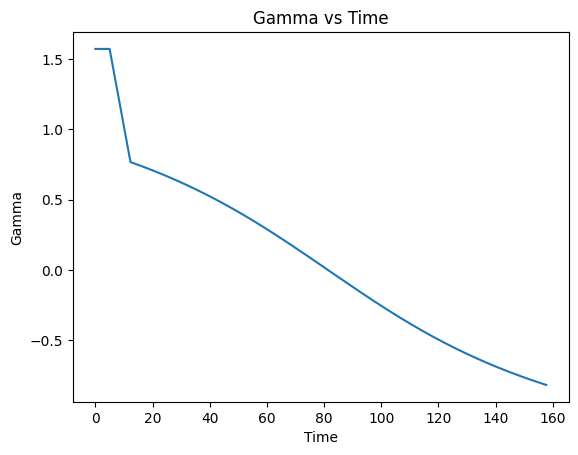

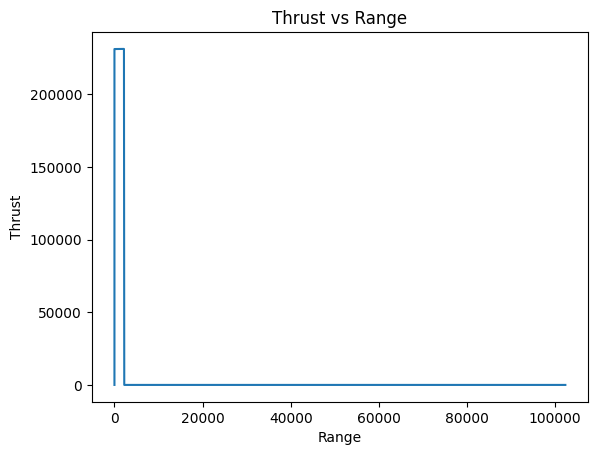

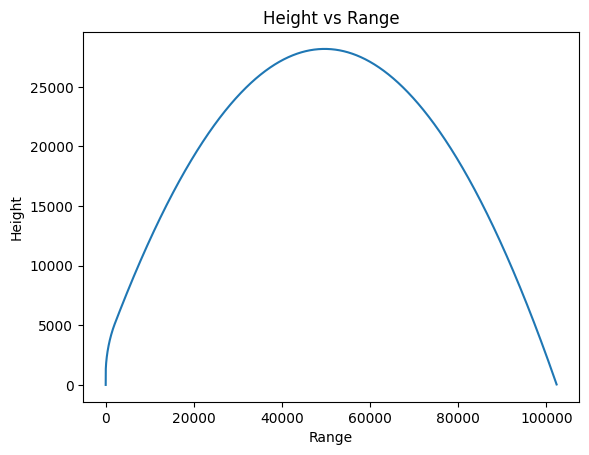

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 3851.5125847536165
Isp0: 416.5472447571308
drymass: 1728.0322067375546
thrust0: 12816.94673429793


Stage 1 burnout
Velocity (km/s):  3.158337907381428
Angle (deg h):  43.6685908454226
Range (km):  73.99955109615043
Time (sec):  125.19999999999716
Final results: 
Range (km):  1312.9379922739029
Apogee (km):  402.7342207343845
Time to target (sec):  706.4000000000921




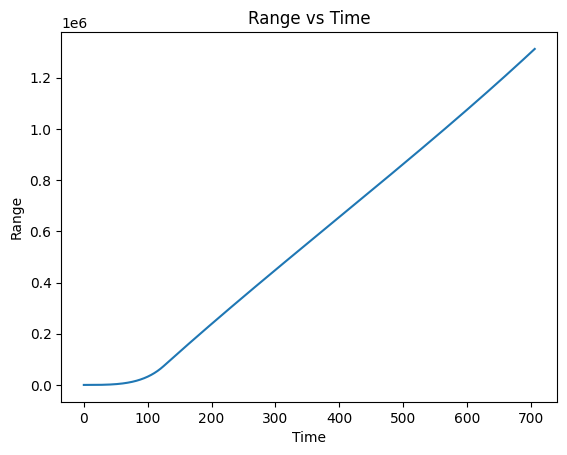

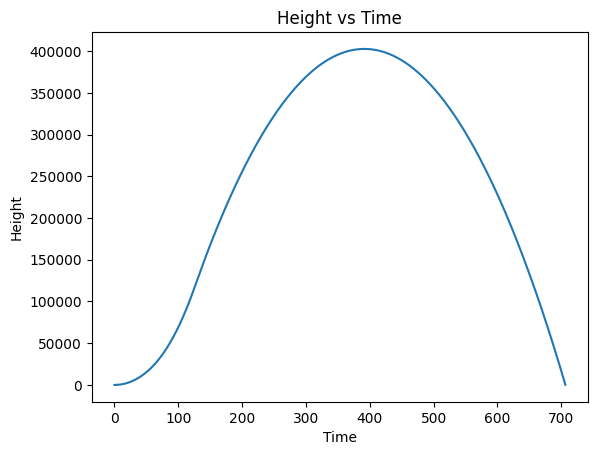

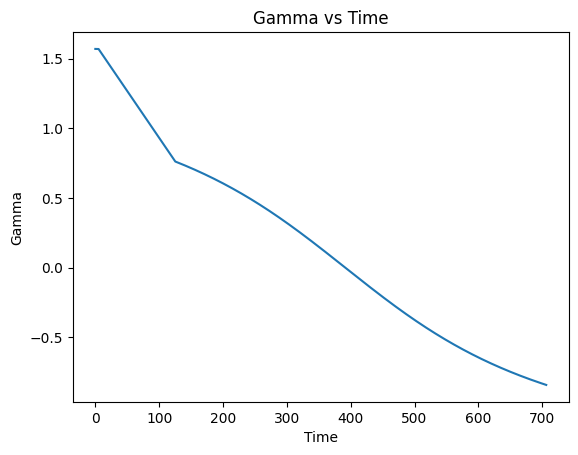

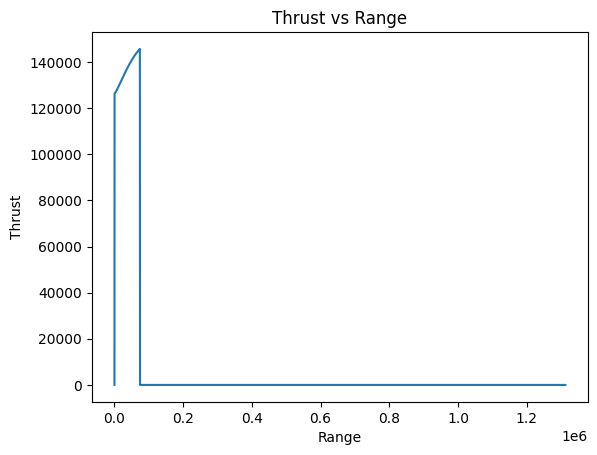

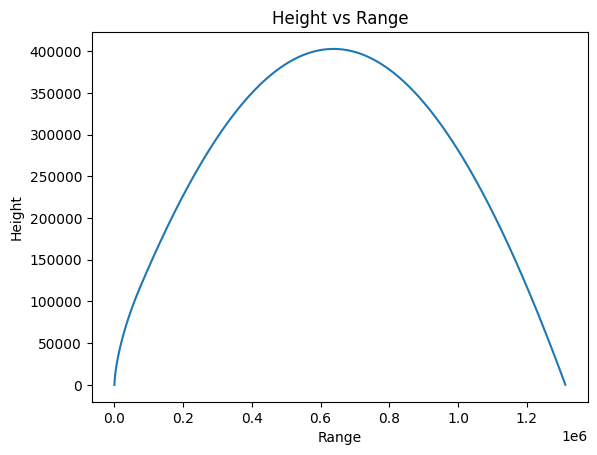

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 5788.742736661839
Isp0: 620.4224402789156
drymass: 2666.424872630143
thrust0: 17804.72288233258


Stage 1 burnout
Velocity (km/s):  5.252980958469834
Angle (deg h):  43.654157698845815
Range (km):  192.9388971741187
Time (sec):  201.69999999999283
Final results: 
Range (km):  4257.916311124139
Apogee (km):  1407.9295086569962
Time to target (sec):  1555.0999999996811




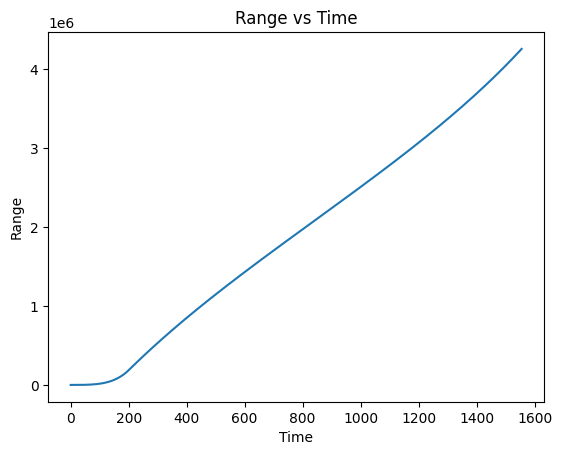

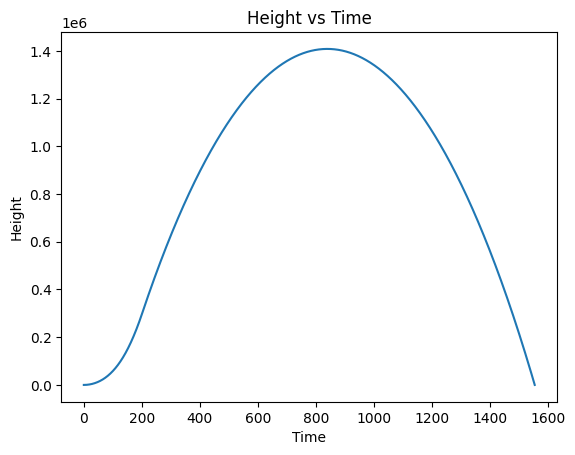

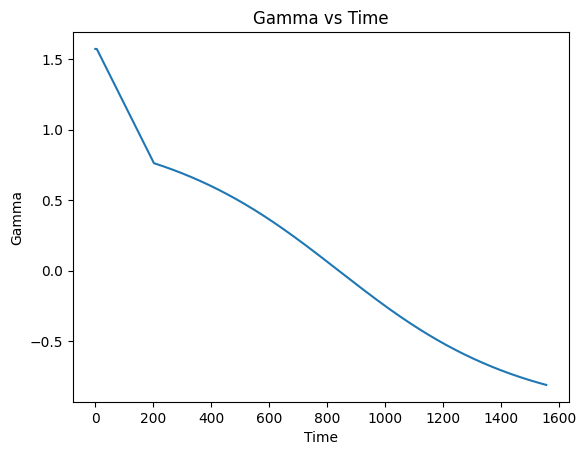

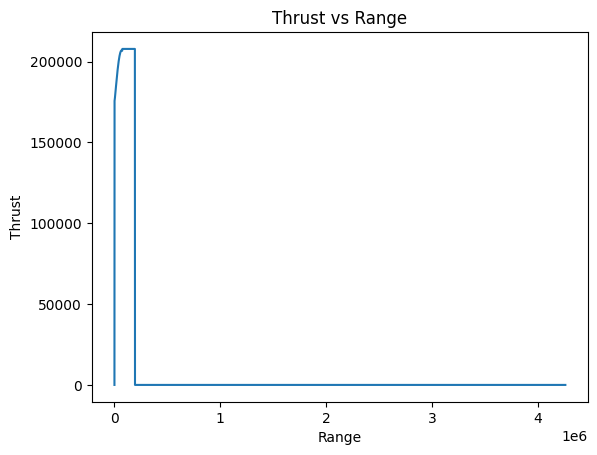

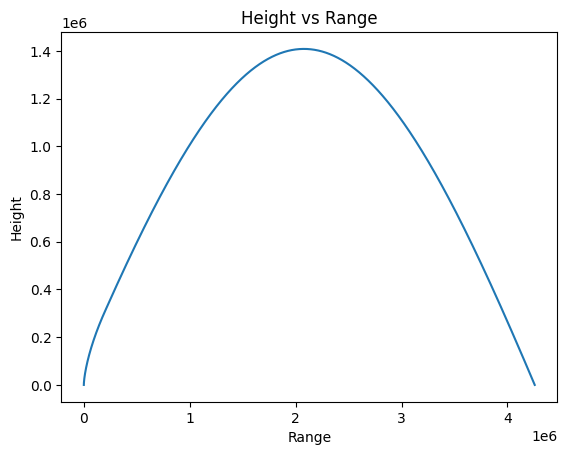

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 1891.1590150070547
Isp0: 249.9309288465159
drymass: 1921.524393675468
thrust0: 27148.733128000673


Stage 1 burnout
Velocity (km/s):  1.150512902100312
Angle (deg h):  43.688110846447636
Range (km):  3.896648652233951
Time (sec):  17.39999999999998
Final results: 
Range (km):  148.37806139156768
Apogee (km):  40.81530963001401
Time to target (sec):  192.39999999999336




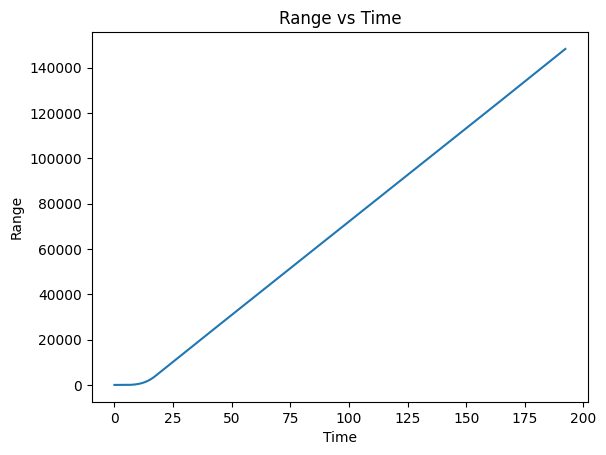

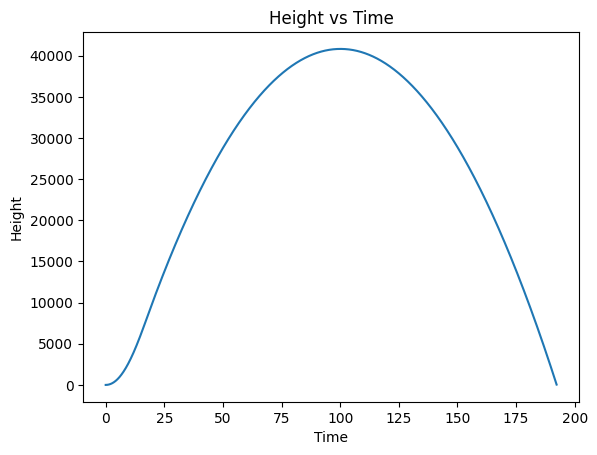

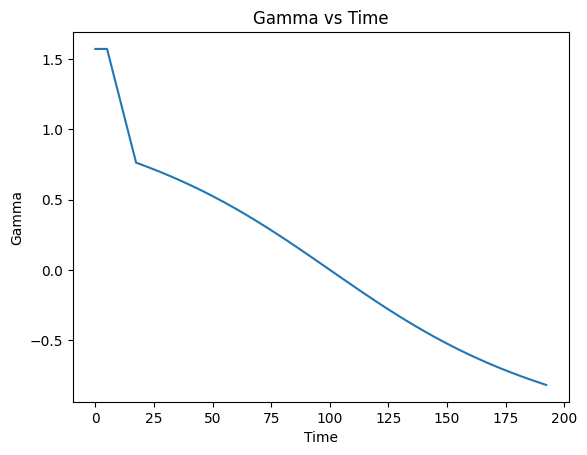

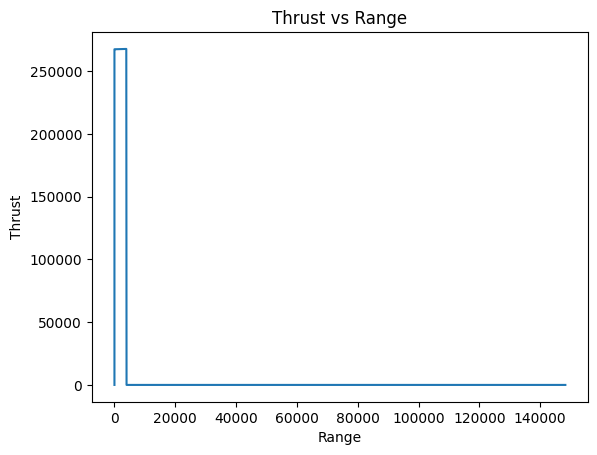

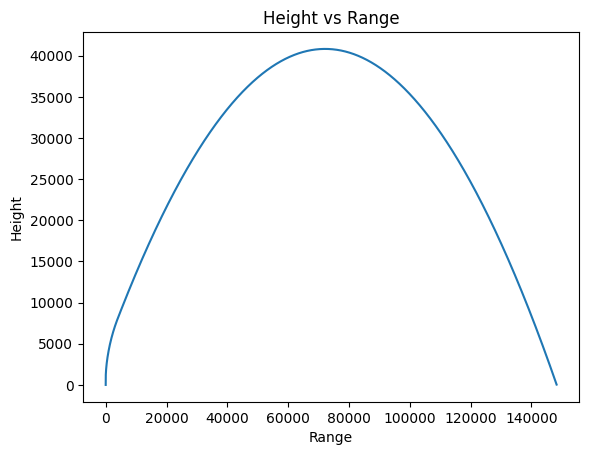

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 3844.3377237984564
Isp0: 542.8664205307355
drymass: 1826.1644836818914
thrust0: 40743.67987877691


Stage 1 burnout
Velocity (km/s):  4.816771014276297
Angle (deg h):  43.66744084515619
Range (km):  48.96213966951488
Time (sec):  51.30000000000046
Final results: 
Range (km):  3060.151858692614
Apogee (km):  880.6570136711308
Time to target (sec):  1070.1000000001222




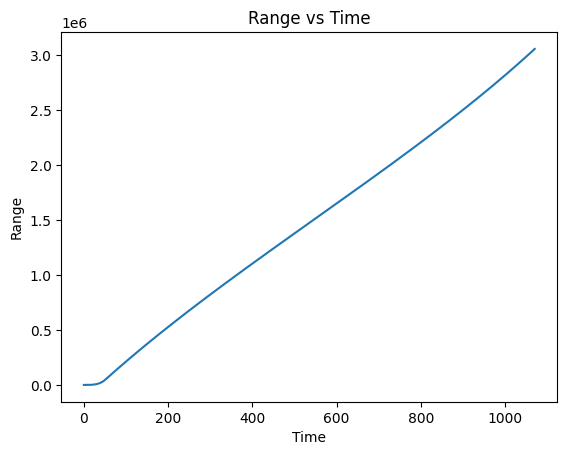

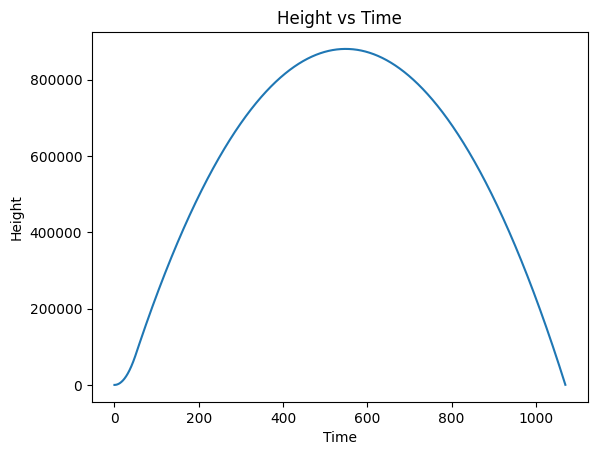

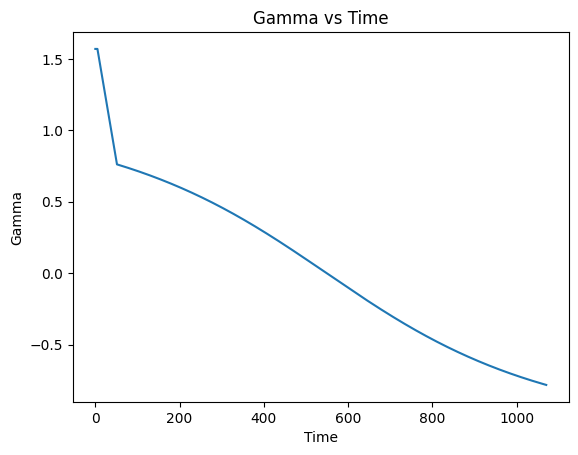

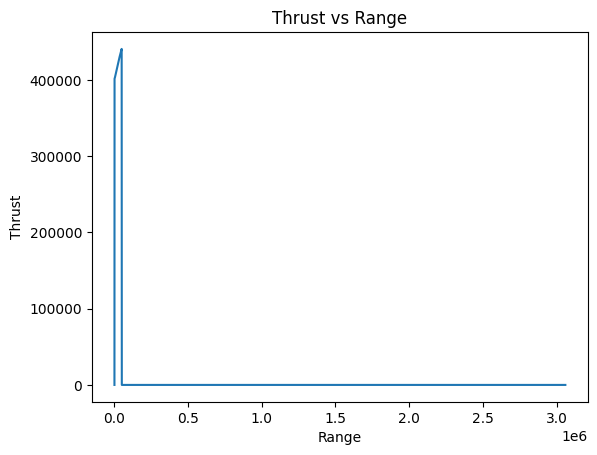

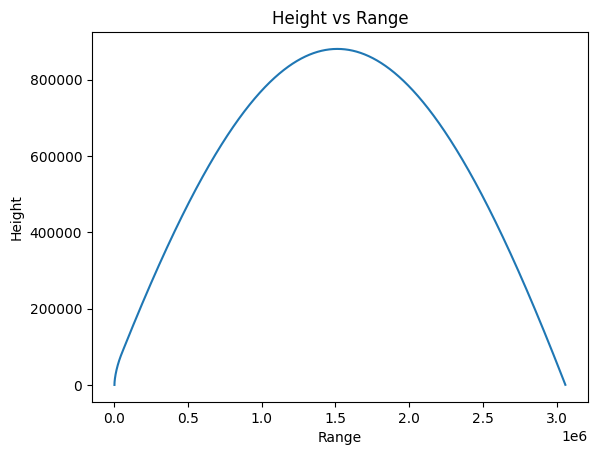

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 3426.177000553903
Isp0: 514.1605386019003
drymass: 2458.115314366244
thrust0: 25128.17627734886


Stage 1 burnout
Velocity (km/s):  3.2916540214421164
Angle (deg h):  43.65420148021981
Range (km):  47.19482983410879
Time (sec):  70.10000000000029
Final results: 
Range (km):  1351.0343920652017
Apogee (km):  388.86852473566324
Time to target (sec):  657.700000000081




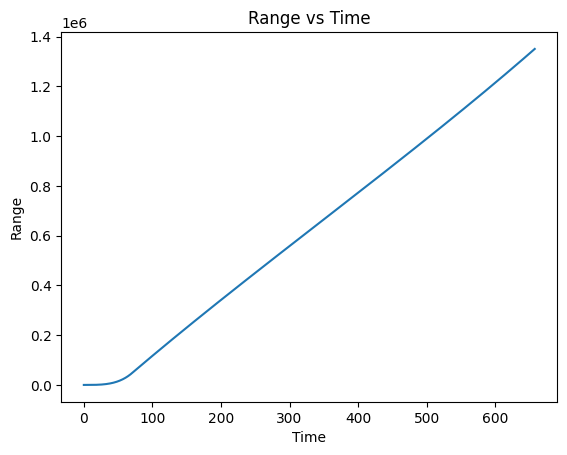

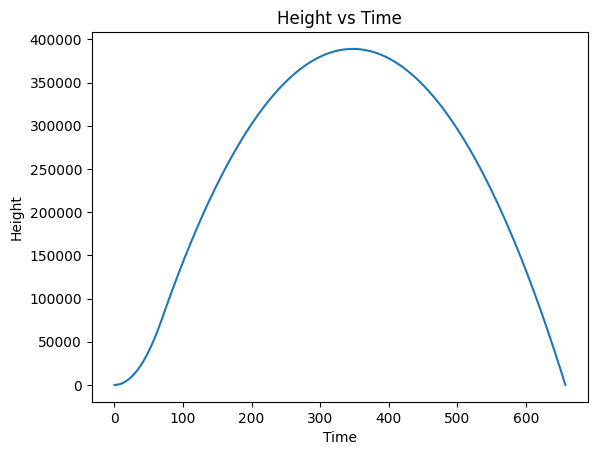

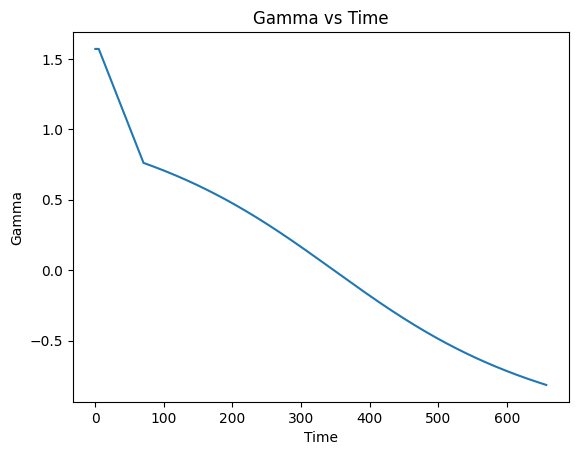

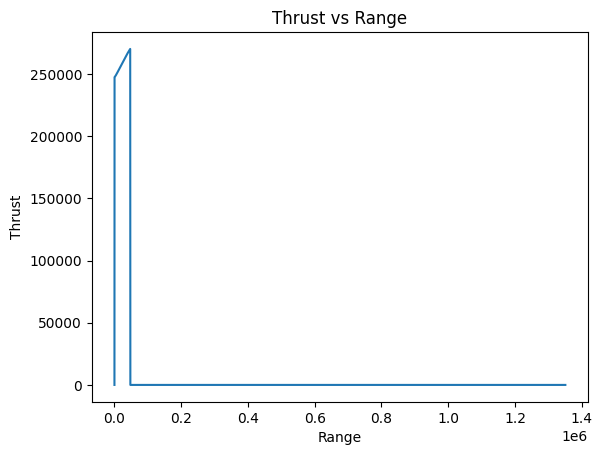

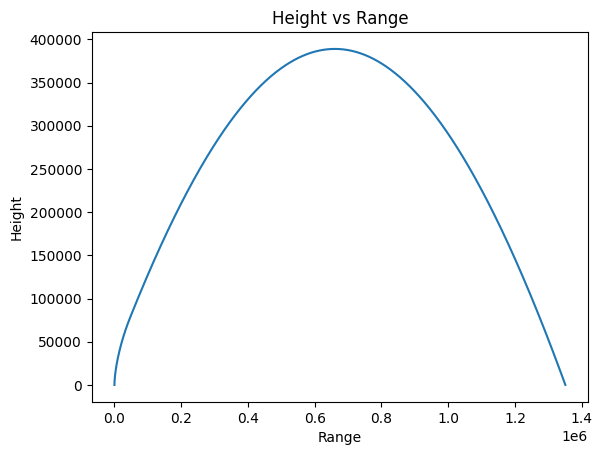

Data written to 'results/results_5.txt'

New simulation 

fuelmass: 5473.578768432625
Isp0: 357.7979522351195
drymass: 1812.5548772829989
thrust0: 47999.92600587852


Stage 1 burnout
Velocity (km/s):  3.8624319174868837
Angle (deg h):  43.65183866762778
Range (km):  29.97198068169995
Time (sec):  40.80000000000031
Final results: 
Range (km):  1823.1566906158362
Apogee (km):  499.16287682397166
Time to target (sec):  746.7000000001012




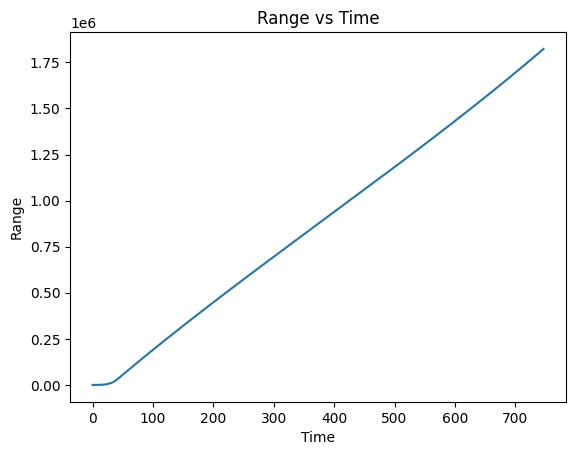

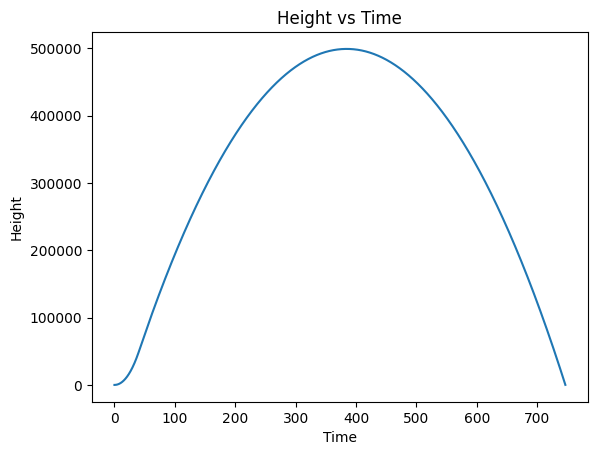

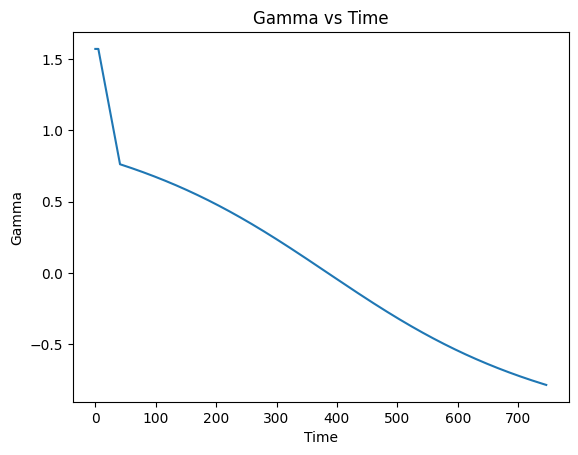

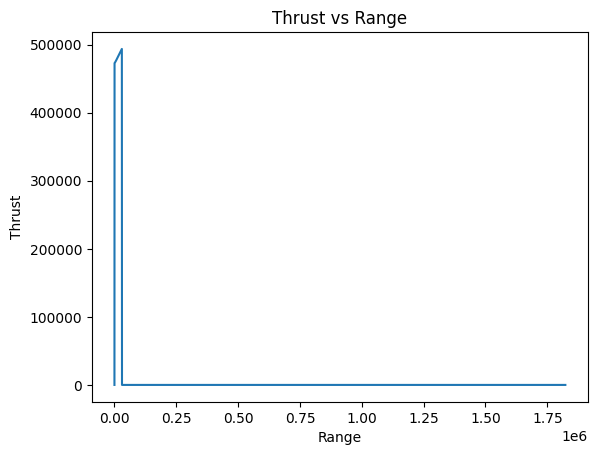

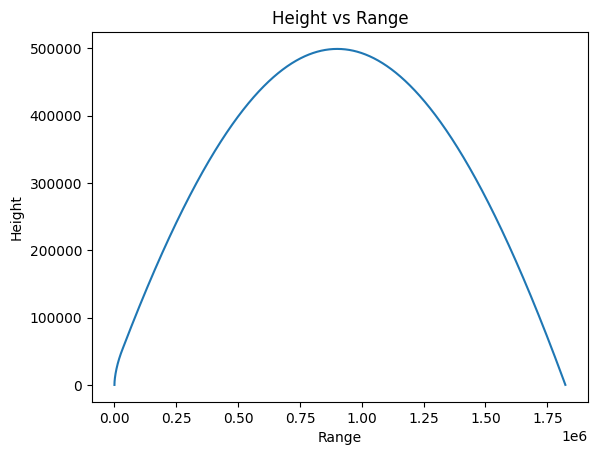

Data written to 'results/results_6.txt'

New simulation 

fuelmass: 3276.427439504267
Isp0: 555.100439682207
drymass: 2646.292308377239
thrust0: 15492.945346734674


Stage 1 burnout
Velocity (km/s):  2.986856436958971
Angle (deg h):  43.67746505485643
Range (km):  70.25517808232614
Time (sec):  117.3999999999976
Final results: 
Range (km):  1176.5927671763002
Apogee (km):  365.5661779981284
Time to target (sec):  662.4000000000821




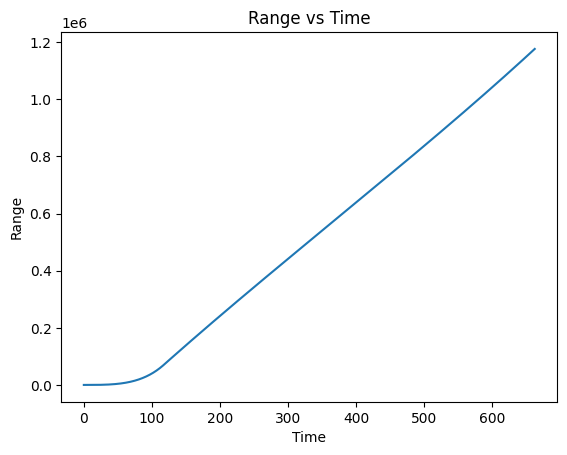

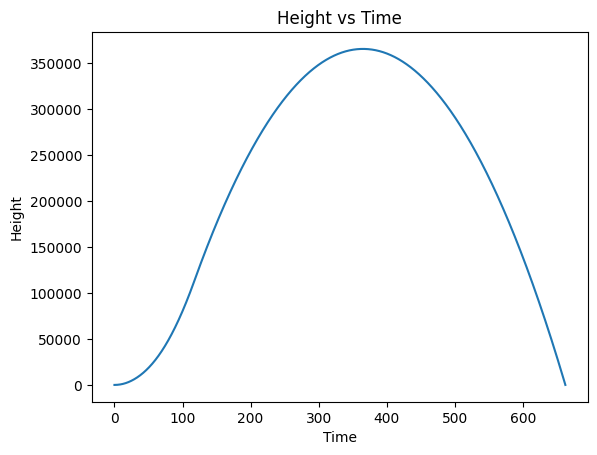

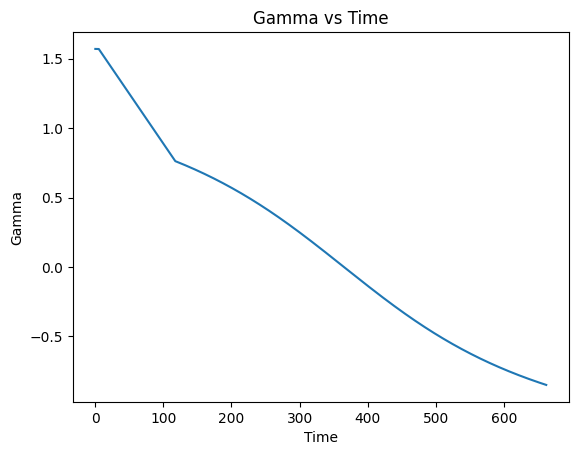

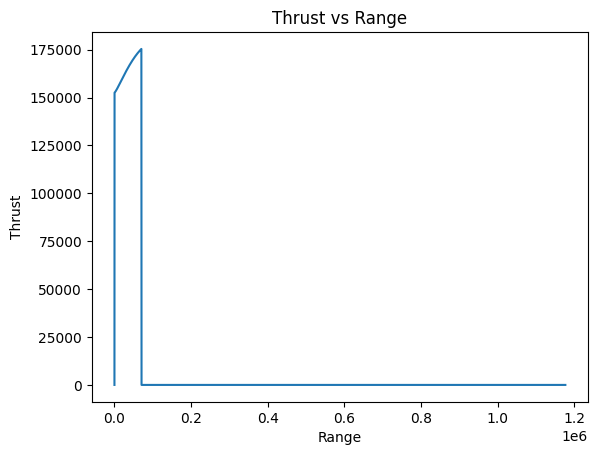

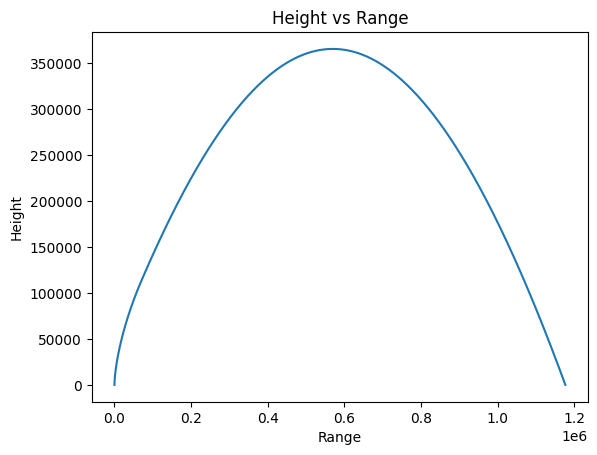

Data written to 'results/results_7.txt'

New simulation 

fuelmass: 2990.223359932745
Isp0: 517.0163497263543
drymass: 1799.9699582937992
thrust0: 57726.131799062125


Stage 1 burnout
Velocity (km/s):  3.8477499639842048
Angle (deg h):  43.8163155984675
Range (km):  20.356867356841715
Time (sec):  26.800000000000114
Final results: 
Range (km):  1779.9636785639134
Apogee (km):  481.9371311693229
Time to target (sec):  722.7000000000958




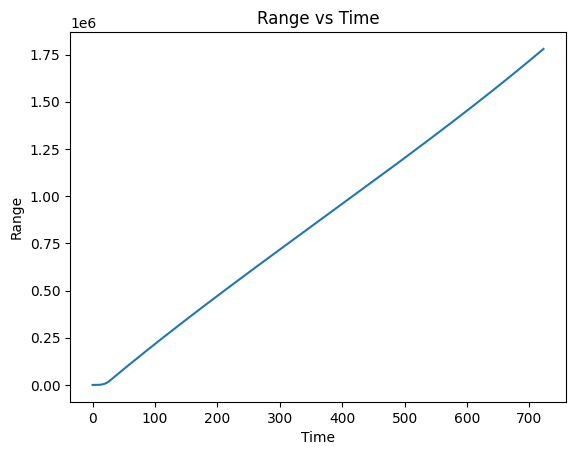

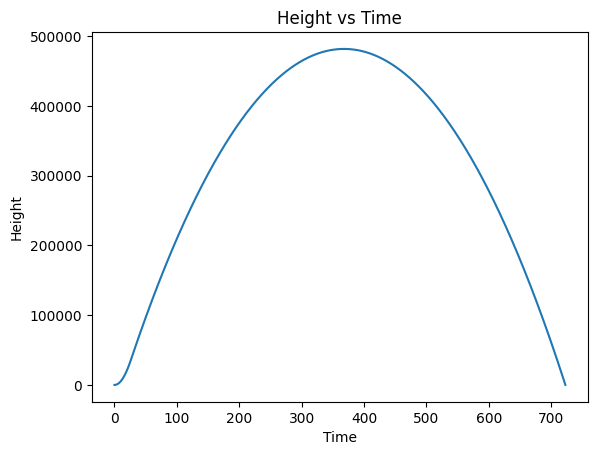

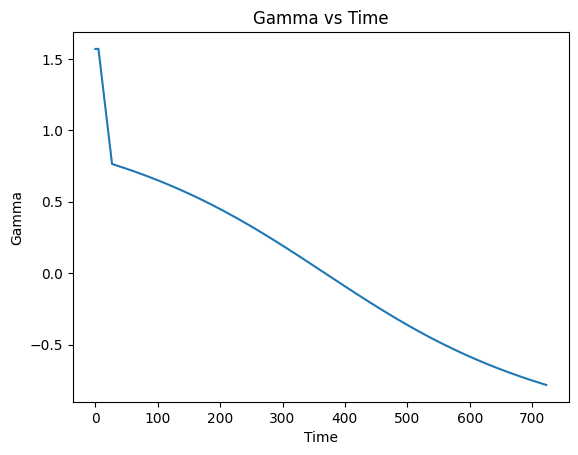

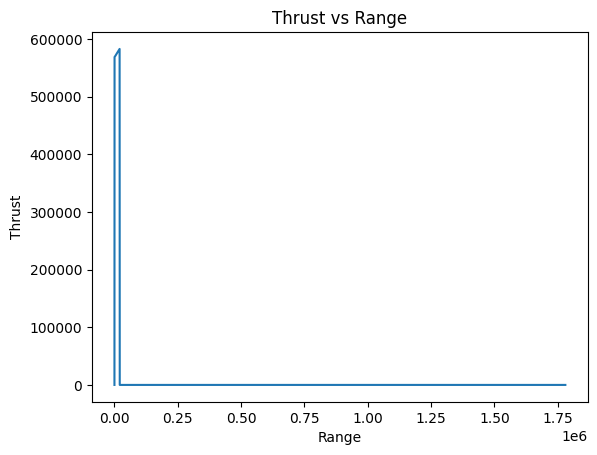

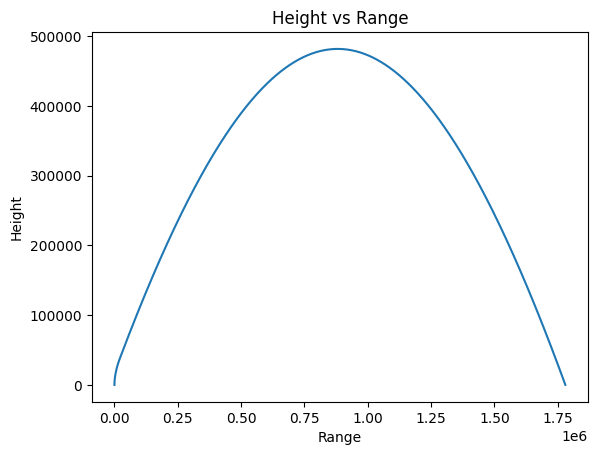

Data written to 'results/results_8.txt'

New simulation 

fuelmass: 5915.779548025615
Isp0: 583.0996555728525
drymass: 2970.1055774831
thrust0: 51384.49612442624


Stage 1 burnout
Velocity (km/s):  5.3601399167239645
Angle (deg h):  43.669973056970086
Range (km):  70.94930627006379
Time (sec):  67.20000000000046
Final results: 
Range (km):  4017.7485821638415
Apogee (km):  1212.4578239827902
Time to target (sec):  1336.7999999998797




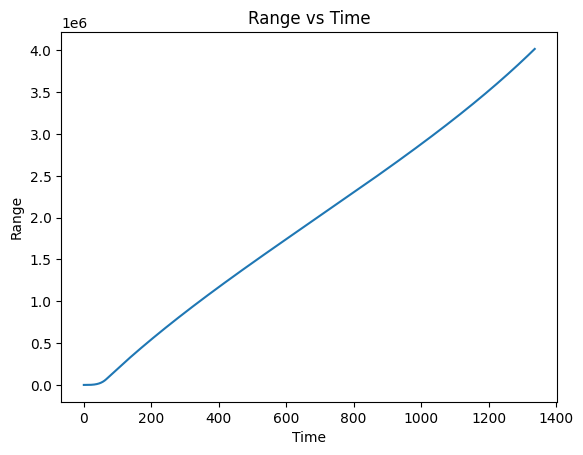

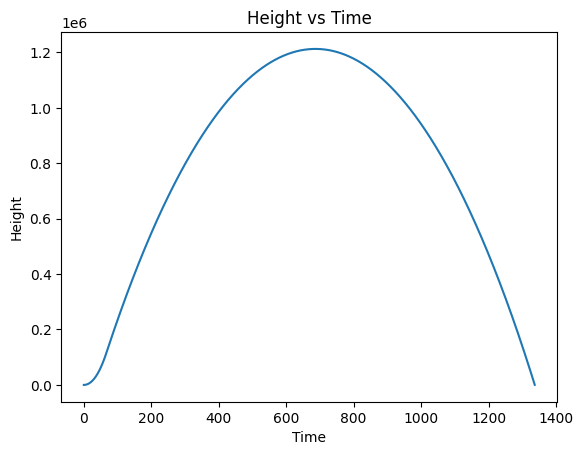

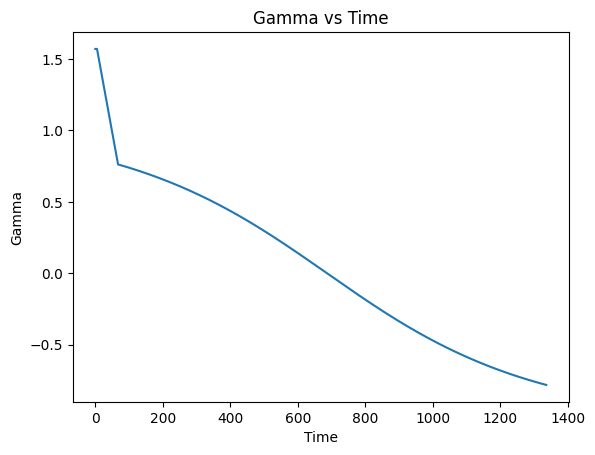

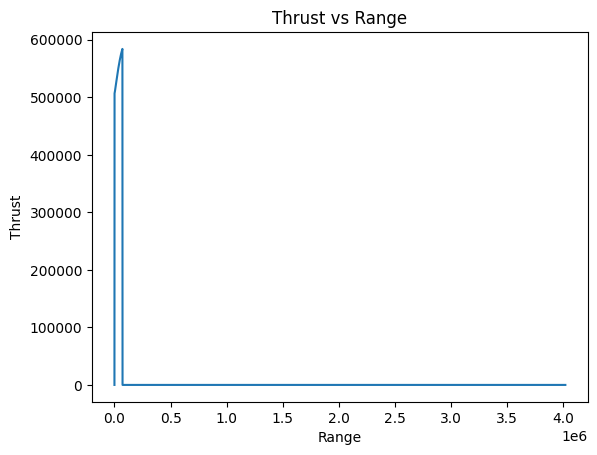

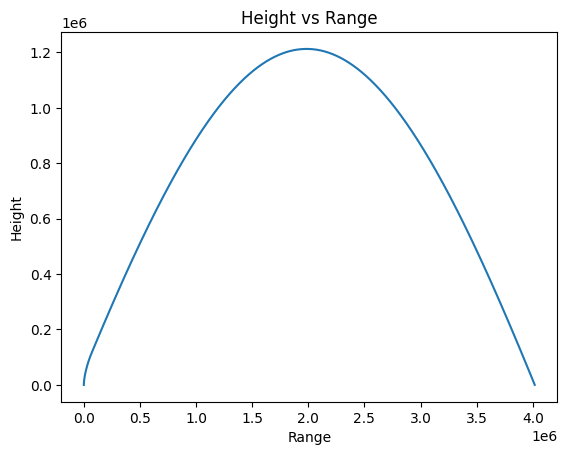

Data written to 'results/results_9.txt'

New simulation 

fuelmass: 5970.09628526568
Isp0: 363.83370295173785
drymass: 1225.366236947296
thrust0: 52695.79304152021


Stage 1 burnout
Velocity (km/s):  5.009344336210637
Angle (deg h):  43.671668588915146
Range (km):  37.45840005033164
Time (sec):  41.30000000000032
Final results: 
Range (km):  3308.098645115162
Apogee (km):  945.6672451048104
Time to target (sec):  1120.5000000000764




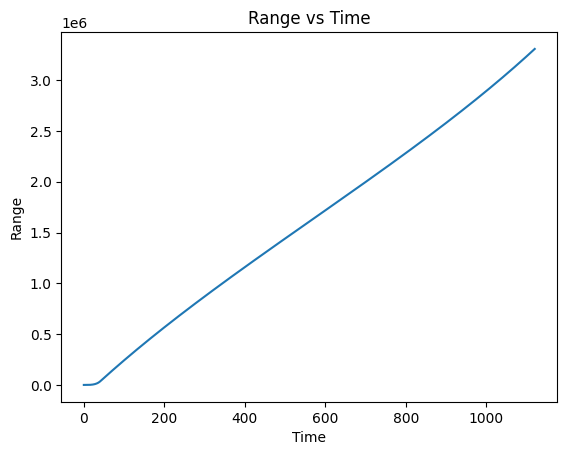

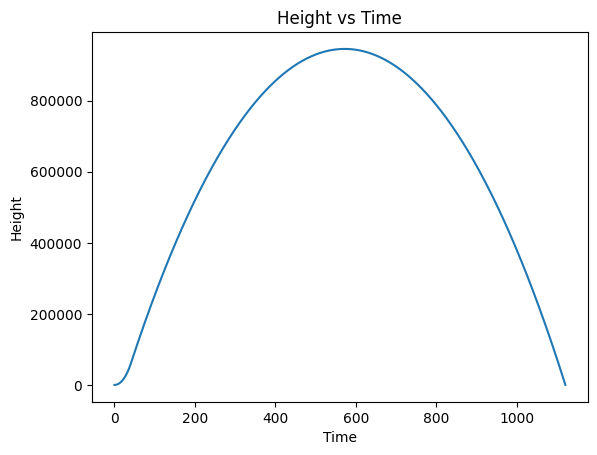

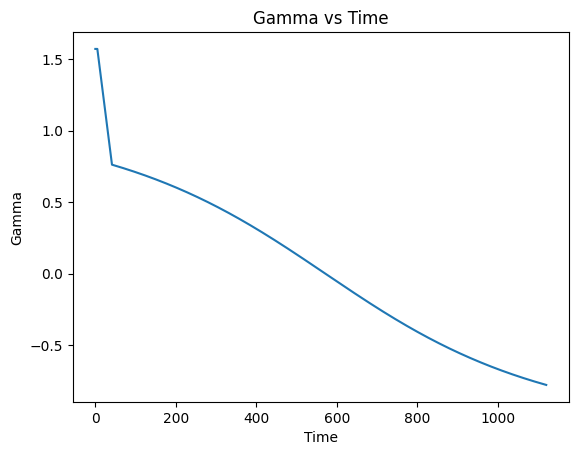

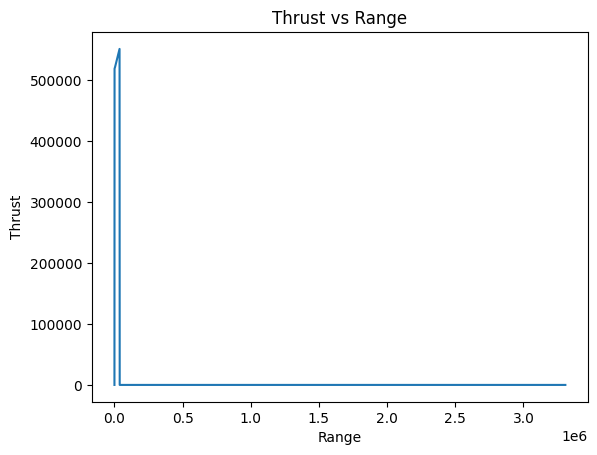

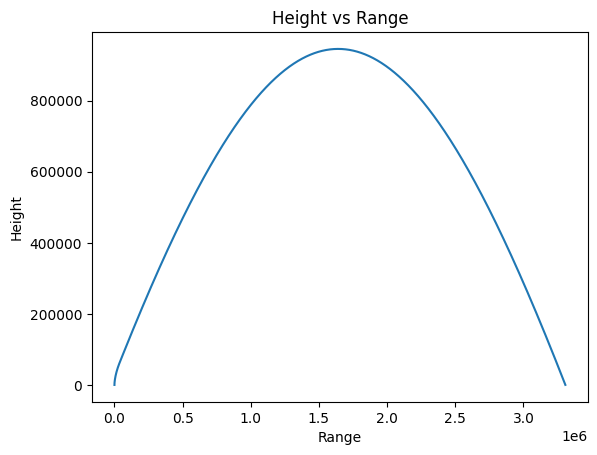

Data written to 'results/results_10.txt'

New simulation 

fuelmass: 3296.968466052975
Isp0: 462.50414684732976
drymass: 2572.154191088235
thrust0: 53376.99680820208


Stage 1 burnout
Velocity (km/s):  2.9462624752506974
Angle (deg h):  43.77228251459069
Range (km):  17.072274180820024
Time (sec):  28.60000000000014
Final results: 
Range (km):  1004.9968999984558
Apogee (km):  269.8620338761796
Time to target (sec):  517.8000000000492




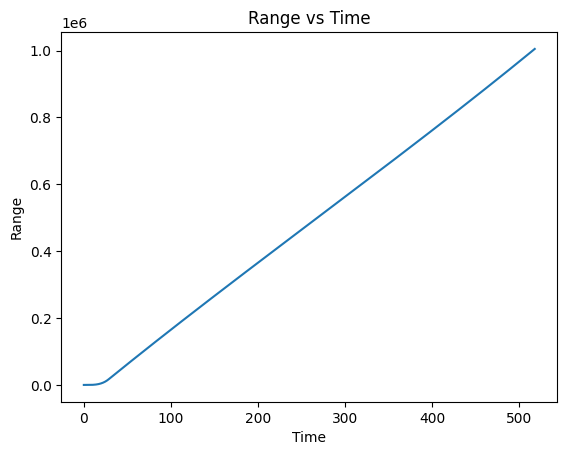

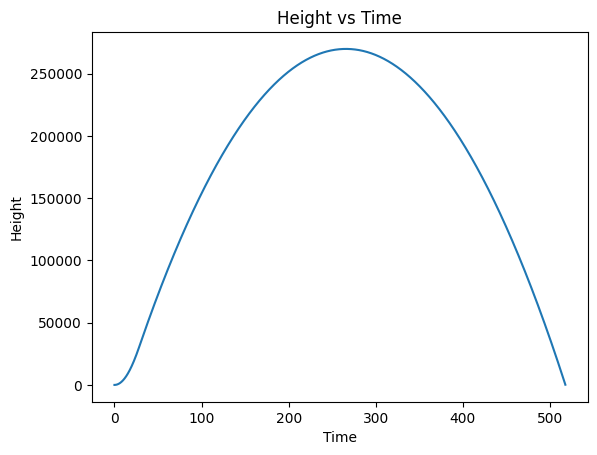

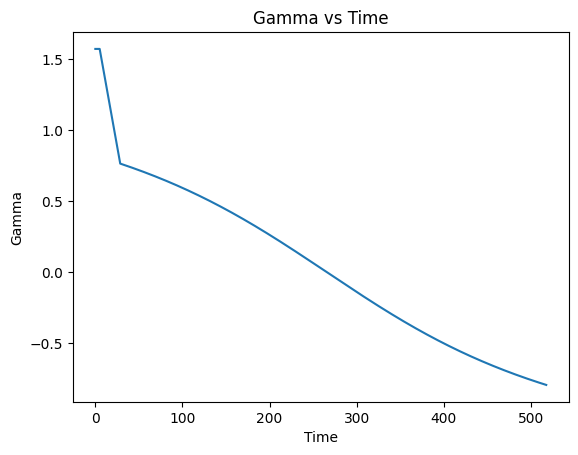

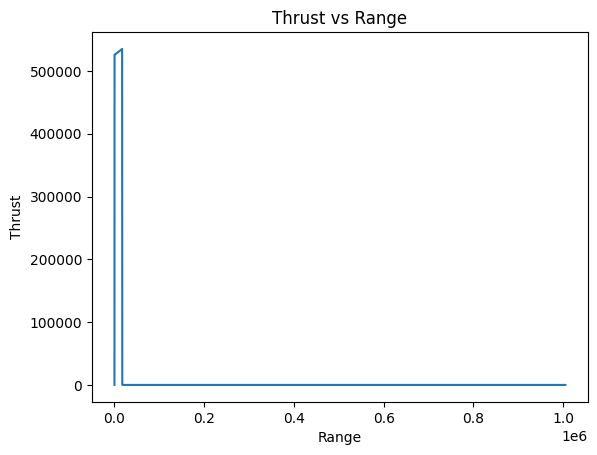

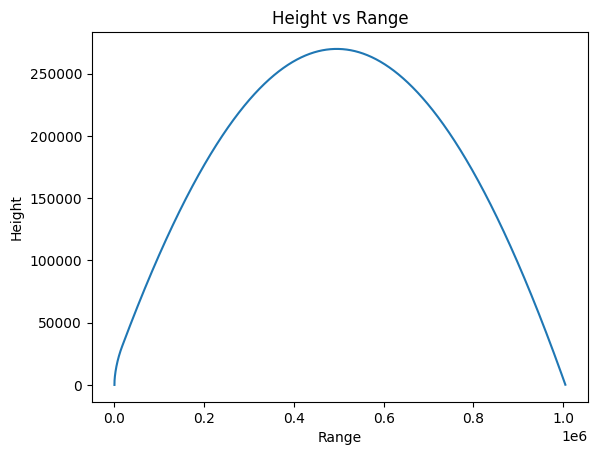

Data written to 'results/results_11.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m3_design = RandomDesign(m3_space)
m3_x = m3_design.get_samples(3*4)
m3_y = neg_run_missile_sim(m3_x)


In [12]:
# Build model
m3_var_kernel = (100)**2 
m3_lengthscale = 100 # 1
m3_var_noise = 1e-5 # small value

constrain_lengthscale = True


m3_rbf_kern = GPy.kern.RBF(input_dim=nr_custom_params, lengthscale=m3_lengthscale)
if constrain_lengthscale:
    m3_rbf_kern.lengthscale.constrain_bounded(m3_lengthscale, m3_lengthscale*1e12)

m3_kern = m3_rbf_kern + \
    GPy.kern.Linear(input_dim=nr_custom_params)

m3_model_gpy = GPRegression(m3_x,m3_y, kernel=m3_kern)
m3_model_gpy.kern.variance =  m3_var_kernel 
m3_model_gpy.likelihood.variance.fix(m3_var_noise)  

display(m3_model_gpy)





reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,100.0,"100.0,100000000000000.0",
sum.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [13]:
m3_model_emukit = GPyModelWrapper(m3_model_gpy)
m3_model_emukit.optimize()

In [14]:
display(m3_model_gpy)



GP_regression.,value,constraints,priors
sum.rbf.variance,697997.5681215449,+ve,
sum.rbf.lengthscale,100.0000000001,"100.0,100000000000000.0",
sum.linear.variances,0.12353460047132474,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [15]:
# # Exact optimization: 
# # - opt1: Greedy: compute simulation on a grid and find maximum
# # - opt2: Minimize package

wirte_output_txt = False
from scipy.optimize import minimize
# # opt2
# func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
def func_to_minimize(x):
    print(x)
    return neg_run_missile_sim(np.array(x).reshape(1,nr_custom_params))

# Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# the others set as defaut
bnds = [(m3_domain_param_1),
        (m3_domain_param_2),
        (m3_domain_param_3),
        (m3_domain_param_4),
#         (m3_domain_param_5),
#         (m3_domain_param_6)
       ]


initial_guess = [np.mean(m3_domain_param_1),
                 np.mean(m3_domain_param_2),
                 np.mean(m3_domain_param_3),
                 np.mean(m3_domain_param_4),
#                  np.mean(m3_domain_param_5),
#                  np.mean(m3_domain_param_6)
                ]
true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



[ 3250.   450.  2000. 39500.]

New simulation 

fuelmass: 3250.0
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.265595650135737
Angle (deg h):  43.67723082354777
Range (km):  24.478932233595803
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.5961059554932
Apogee (km):  344.1630357716314
Time to target (sec):  598.3000000000675


[ 3250.00000001   450.          2000.         39500.        ]

New simulation 

fuelmass: 3250.00000001
Isp0: 450.0
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956501256957
Angle (deg h):  43.6772308237112
Range (km):  24.478932233455883
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.596105948389
Apogee (km):  344.1630357711632
Time to target (sec):  598.3000000000675


[ 3250.           450.00000001  2000.         39500.        ]

New simulation 

fuelmass: 3250.0
Isp0: 450.00000001
drymass: 2000.0
thrust0: 39500.0


Stage 1 burnout
Velocity (km/s):  3.2655956

Final results: 
Range (km):  1265.6184188138257
Apogee (km):  344.16180003058287
Time to target (sec):  598.3000000000675


[ 3249.99919961   449.9950651   1999.99966788 39500.00009504]

New simulation 

fuelmass: 3249.999199610407
Isp0: 449.9950650974901
drymass: 1999.9996678836703
thrust0: 39500.00009504344


Stage 1 burnout
Velocity (km/s):  3.265619739370602
Angle (deg h):  43.67663032621853
Range (km):  24.479328246429386
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6184188175228
Apogee (km):  344.16180003298564
Time to target (sec):  598.3000000000675


[ 3249.99842576   449.99029384  1999.99934678 39500.00018692]

New simulation 

fuelmass: 3249.9984257618607
Isp0: 449.99029383713753
drymass: 1999.9993467803713
thrust0: 39500.00018691556


Stage 1 burnout
Velocity (km/s):  3.2656430306924014
Angle (deg h):  43.67604972697668
Range (km):  24.47971113892694
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6399925235085
Apogee (km):  344.16060516

Final results: 
Range (km):  1265.6502620699382
Apogee (km):  344.1600363502034
Time to target (sec):  598.3000000000675


[ 3249.9980574    449.98802267  1999.99919393 39500.00023066]

New simulation 

fuelmass: 3249.998057402487
Isp0: 449.98802267117617
drymass: 1999.999193932103
thrust0: 39500.00023066233


Stage 1 burnout
Velocity (km/s):  3.265654117896748
Angle (deg h):  43.675773351098755
Range (km):  24.479893403460036
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.6502620736276
Apogee (km):  344.1600363526068
Time to target (sec):  598.3000000000675


[ 3249.98690521   449.91926242  1999.9945664  39500.0015548 ]

New simulation 

fuelmass: 3249.9869052086783
Isp0: 449.91926242030064
drymass: 1999.9945664035754
thrust0: 39500.00155479667


Stage 1 burnout
Velocity (km/s):  3.2506266152105123
Angle (deg h):  43.6776190651224
Range (km):  24.251037006218706
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.2165005927834
Apogee (km):  340.76330786

Final results: 
Range (km):  1253.1811019118843
Apogee (km):  340.76532695862187
Time to target (sec):  594.9000000000667


[ 3249.98818913   449.9271786   1999.99509916 39500.00140235]

New simulation 

fuelmass: 3249.98818912851
Isp0: 449.92717859919287
drymass: 1999.9950991575563
thrust0: 39500.00140235176


Stage 1 burnout
Velocity (km/s):  3.2505883392726025
Angle (deg h):  43.67858271073192
Range (km):  24.25040798930061
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1811018756027
Apogee (km):  340.7653269618396
Time to target (sec):  594.9000000000667


[ 3249.98818913   449.92717859  1999.99509917 39500.00140235]

New simulation 

fuelmass: 3249.98818912851
Isp0: 449.92717858919286
drymass: 1999.9950991675562
thrust0: 39500.00140235176


Stage 1 burnout
Velocity (km/s):  3.250588339308714
Angle (deg h):  43.67858270954315
Range (km):  24.250407990002987
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1811019159943
Apogee (km):  340.765326956

Final results: 
Range (km):  1265.856773008944
Apogee (km):  344.14859488365835
Time to target (sec):  598.3000000000675


[ 3249.99065131   449.94235944  1999.99612082 39500.00111001]

New simulation 

fuelmass: 3249.990651314277
Isp0: 449.94235944296554
drymass: 1999.9961208209884
thrust0: 39500.00111000783


Stage 1 burnout
Velocity (km/s):  3.265877075316588
Angle (deg h):  43.670215953061344
Range (km):  24.483558492409013
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8567730017655
Apogee (km):  344.1485948832219
Time to target (sec):  598.3000000000675


[ 3249.9906513    449.94235945  1999.99612082 39500.00111001]

New simulation 

fuelmass: 3249.990651304277
Isp0: 449.94235945296555
drymass: 1999.9961208209884
thrust0: 39500.00111000783


Stage 1 burnout
Velocity (km/s):  3.265877075280106
Angle (deg h):  43.67021595408441
Range (km):  24.483558491775806
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8567729650988
Apogee (km):  344.148594886

Final results: 
Range (km):  1232.1473271601342
Apogee (km):  335.20093965673396
Time to target (sec):  589.2000000000654


[ 3249.27848492   445.55166464  1999.70120869 39500.07596478]

New simulation 

fuelmass: 3249.278484917429
Isp0: 445.55166463920364
drymass: 1999.7012086857324
thrust0: 39500.075964779586


Stage 1 burnout
Velocity (km/s):  3.2257612161316582
Angle (deg h):  43.715253430038544
Range (km):  23.89883580076853
Time (sec):  36.70000000000025
Final results: 
Range (km):  1232.1473271638683
Apogee (km):  335.2009396590608
Time to target (sec):  589.2000000000654


[ 3249.942886     449.64787349  1999.97634046 39500.00613838]

New simulation 

fuelmass: 3249.942886004975
Isp0: 449.6478734875088
drymass: 1999.976340458389
thrust0: 39500.00613838127


Stage 1 burnout
Velocity (km/s):  3.251940136989925
Angle (deg h):  43.77916170608737
Range (km):  24.272618963702506
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7304682023355
Apogee (km):  342.09555558

Final results: 
Range (km):  1265.87395601451
Apogee (km):  344.1476426013971
Time to target (sec):  598.3000000000675


[ 3249.99003518   449.93856063  1999.99586517 39500.00118316]

New simulation 

fuelmass: 3249.990035177053
Isp0: 449.93856063338455
drymass: 1999.9958651734746
thrust0: 39500.001183156994


Stage 1 burnout
Velocity (km/s):  3.265895627186001
Angle (deg h):  43.66975356357008
Range (km):  24.483863444962743
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8739560555105
Apogee (km):  344.14764259643954
Time to target (sec):  598.3000000000675


[ 3249.99003518   449.93856063  1999.99586516 39500.00118317]

New simulation 

fuelmass: 3249.990035177053
Isp0: 449.93856063338455
drymass: 1999.9958651634747
thrust0: 39500.00118316699


Stage 1 burnout
Velocity (km/s):  3.2658956271973816
Angle (deg h):  43.66975356355732
Range (km):  24.48386344504265
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8739560592041
Apogee (km):  344.1476425988

Final results: 
Range (km):  1265.8796023195246
Apogee (km):  344.1473295718446
Time to target (sec):  598.3000000000675


[ 3249.9898327    449.93731232  1999.99578133 39500.00120444]

New simulation 

fuelmass: 3249.9898327018623
Isp0: 449.9373123201527
drymass: 1999.9957813274978
thrust0: 39500.00120443648


Stage 1 burnout
Velocity (km/s):  3.2659017230067726
Angle (deg h):  43.66960162103307
Range (km):  24.4839636505561
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8796023604848
Apogee (km):  344.1473295668576
Time to target (sec):  598.3000000000675


[ 3249.9898327    449.93731232  1999.99578132 39500.00120445]

New simulation 

fuelmass: 3249.9898327018623
Isp0: 449.9373123201527
drymass: 1999.9957813174979
thrust0: 39500.001204446475


Stage 1 burnout
Velocity (km/s):  3.2659017230182834
Angle (deg h):  43.669601621020306
Range (km):  24.483963650636753
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.879602364213
Apogee (km):  344.147329569

Final results: 
Range (km):  1265.8798139818919
Apogee (km):  344.1473178345654
Time to target (sec):  598.3000000000675


[ 3249.98982511   449.93726553  1999.99577817 39500.00120524]

New simulation 

fuelmass: 3249.989825113201
Isp0: 449.937265534045
drymass: 1999.9957781749958
thrust0: 39500.00120524402


Stage 1 burnout
Velocity (km/s):  3.2659019514875895
Angle (deg h):  43.66959592627867
Range (km):  24.483967406302888
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.87981398563
Apogee (km):  344.14731783700154
Time to target (sec):  598.3000000000675


[ 3249.98982379   449.93725736  1999.99577763 39500.00120537]

New simulation 

fuelmass: 3249.989823786714
Isp0: 449.9372573559014
drymass: 1999.995777625691
thrust0: 39500.00120537343


Stage 1 burnout
Velocity (km/s):  3.2659019914221634
Angle (deg h):  43.66959493085873
Range (km):  24.483968062772263
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8798509759658
Apogee (km):  344.1473157860063

Final results: 
Range (km):  1265.881123874643
Apogee (km):  344.1472452163802
Time to target (sec):  598.3000000000675


[ 3249.98975657   449.93684296  1999.99574979 39500.00121244]

New simulation 

fuelmass: 3249.989756571873
Isp0: 449.9368429585862
drymass: 1999.9957497916932
thrust0: 39500.00121243749


Stage 1 burnout
Velocity (km/s):  3.2659040150404026
Angle (deg h):  43.66954449089975
Range (km):  24.48400132778684
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817253680052
Apogee (km):  344.1472118691259
Time to target (sec):  598.3000000000675


[ 3249.98975658   449.93684296  1999.99574979 39500.00121244]

New simulation 

fuelmass: 3249.989756581873
Isp0: 449.9368429585862
drymass: 1999.9957497916932
thrust0: 39500.00121243749


Stage 1 burnout
Velocity (km/s):  3.265904015030359
Angle (deg h):  43.66954449106319
Range (km):  24.484001327646943
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817253608856
Apogee (km):  344.1472118686568

Final results: 
Range (km):  1253.1389058746345
Apogee (km):  340.76774387564006
Time to target (sec):  594.9000000000667


[ 3249.98968656   449.93662358  1999.99570888 39500.00127859]

New simulation 

fuelmass: 3249.989686557659
Isp0: 449.93662358078706
drymass: 1999.9957088782005
thrust0: 39500.00127858527


Stage 1 burnout
Velocity (km/s):  3.2505427431020166
Angle (deg h):  43.67973176139213
Range (km):  24.249658273181748
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1389058783946
Apogee (km):  340.76774387801345
Time to target (sec):  594.9000000000667


[ 3249.98975657   449.93684296  1999.99574979 39500.00121244]

New simulation 

fuelmass: 3249.9897565709316
Isp0: 449.93684295563656
drymass: 1999.9957497911432
thrust0: 39500.00121243838


Stage 1 burnout
Velocity (km/s):  3.265904015055784
Angle (deg h):  43.66954449053276
Range (km):  24.48400132803342
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817253818306
Apogee (km):  344.147211

Final results: 
Range (km):  1265.881725355287
Apogee (km):  344.1472118704456
Time to target (sec):  598.3000000000675


[ 3249.98975657   449.93684295  1999.9957498  39500.00121244]

New simulation 

fuelmass: 3249.9897565697534
Isp0: 449.936842951945
drymass: 1999.9957498004546
thrust0: 39500.00121243949


Stage 1 burnout
Velocity (km/s):  3.2659040150649674
Angle (deg h):  43.66954449007269
Range (km):  24.48400132827712
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817253961774
Apogee (km):  344.1472118654975
Time to target (sec):  598.3000000000675


[ 3249.98975657   449.93684295  1999.99574979 39500.00121245]

New simulation 

fuelmass: 3249.9897565697534
Isp0: 449.936842951945
drymass: 1999.9957497904547
thrust0: 39500.00121244949


Stage 1 burnout
Velocity (km/s):  3.2659040150764365
Angle (deg h):  43.66954449005765
Range (km):  24.484001328359163
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881725399955
Apogee (km):  344.1472118678984

Final results: 
Range (km):  1265.8817275168506
Apogee (km):  344.1472117713711
Time to target (sec):  598.3000000000675


[ 3249.98975643   449.93684251  1999.99574971 39500.00121258]

New simulation 

fuelmass: 3249.9897564252483
Isp0: 449.93684250916283
drymass: 1999.9957497060118
thrust0: 39500.001212576


Stage 1 burnout
Velocity (km/s):  3.265904017384071
Angle (deg h):  43.66954443480472
Range (km):  24.484001365471254
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817274801604
Apogee (km):  344.14721177458944
Time to target (sec):  598.3000000000675


[ 3249.98975643   449.9368425   1999.99574972 39500.00121258]

New simulation 

fuelmass: 3249.9897564252483
Isp0: 449.9368424991628
drymass: 1999.9957497160117
thrust0: 39500.001212576


Stage 1 burnout
Velocity (km/s):  3.2659040174204987
Angle (deg h):  43.669544433615314
Range (km):  24.484001366180404
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817275210154
Apogee (km):  344.1472117696

Final results: 
Range (km):  1265.8817275252409
Apogee (km):  344.14721177198265
Time to target (sec):  598.3000000000675


[ 3249.98975207   449.93682885  1999.99574716 39500.00121669]

New simulation 

fuelmass: 3249.9897520675704
Isp0: 449.9368288451094
drymass: 1999.9957471595599
thrust0: 39500.001216692406


Stage 1 burnout
Velocity (km/s):  3.265904088462917
Angle (deg h):  43.66954273109241
Range (km):  24.484002509248175
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817915999357
Apogee (km):  344.14720888019497
Time to target (sec):  598.3000000000675


[ 3249.98975208   449.93682885  1999.99574716 39500.00121669]

New simulation 

fuelmass: 3249.9897520775703
Isp0: 449.9368288451094
drymass: 1999.9957471595599
thrust0: 39500.001216692406


Stage 1 burnout
Velocity (km/s):  3.2659040884528747
Angle (deg h):  43.669542731255845
Range (km):  24.484002509108265
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8817915928169
Apogee (km):  344.1472

Final results: 
Range (km):  1265.88183585779
Apogee (km):  344.1472068836695
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.9368194   1999.99574541 39500.00121954]

New simulation 

fuelmass: 3249.989749054702
Isp0: 449.9368194047908
drymass: 1999.9957454089604
thrust0: 39500.00121953846


Stage 1 burnout
Velocity (km/s):  3.26590413756437
Angle (deg h):  43.669541553979656
Range (km):  24.484003299448144
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818358986773
Apogee (km):  344.14720687872176
Time to target (sec):  598.3000000000675


[ 3249.98974905   449.9368194   1999.9957454  39500.00121955]

New simulation 

fuelmass: 3249.989749054702
Isp0: 449.9368194047908
drymass: 1999.9957453989605
thrust0: 39500.00121954846


Stage 1 burnout
Velocity (km/s):  3.2659041375758426
Angle (deg h):  43.66954155396463
Range (km):  24.484003299530208
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818359024656
Apogee (km):  344.147206881120

Final results: 
Range (km):  1253.415988706616
Apogee (km):  340.75479338492624
Time to target (sec):  594.9000000000667


[ 3249.97064669   449.87690609  1999.9845723  39500.01933458]

New simulation 

fuelmass: 3249.970646688747
Isp0: 449.87690608642896
drymass: 1999.9845722961077
thrust0: 39500.019334578996


Stage 1 burnout
Velocity (km/s):  3.2508504116600268
Angle (deg h):  43.67228457070098
Range (km):  24.25460677282219
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.4159886995765
Apogee (km):  340.75479338446866
Time to target (sec):  594.9000000000667


[ 3249.97064668   449.8769061   1999.9845723  39500.01933458]

New simulation 

fuelmass: 3249.970646678747
Isp0: 449.87690609642897
drymass: 1999.9845722961077
thrust0: 39500.019334578996


Stage 1 burnout
Velocity (km/s):  3.2508504116239383
Angle (deg h):  43.6722845717269
Range (km):  24.25460677219388
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.4159886632679
Apogee (km):  340.754793

Final results: 
Range (km):  1265.8818360863083
Apogee (km):  344.14720687022356
Time to target (sec):  598.3000000000675


[ 3249.98974904   449.93681936  1999.99574539 39500.00121956]

New simulation 

fuelmass: 3249.9897490419544
Isp0: 449.9368193648094
drymass: 1999.9957453915044
thrust0: 39500.001219560545


Stage 1 burnout
Velocity (km/s):  3.2659041377838904
Angle (deg h):  43.66954154898106
Range (km):  24.48400330287639
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881836090062
Apogee (km):  344.1472068726847
Time to target (sec):  598.3000000000675


[ 3249.98971382   449.93670889  1999.99572479 39500.00125295]

New simulation 

fuelmass: 3249.9897138174947
Isp0: 449.9367088856586
drymass: 1999.9957247884909
thrust0: 39500.00125295438


Stage 1 burnout
Velocity (km/s):  3.250542303668109
Angle (deg h):  43.679742398661084
Range (km):  24.249651205085968
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.138510125825
Apogee (km):  340.76776236

Final results: 
Range (km):  1253.1382538713844
Apogee (km):  340.76777433505737
Time to target (sec):  594.9000000000667


[ 3249.98973143   449.93676413  1999.99573509 39500.00123625]

New simulation 

fuelmass: 3249.9897314294853
Isp0: 449.9367641344844
drymass: 1999.9957350898578
thrust0: 39500.00123625269


Stage 1 burnout
Velocity (km/s):  3.250542019094203
Angle (deg h):  43.679749287451436
Range (km):  24.249646627803656
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.138253835156
Apogee (km):  340.76777433824475
Time to target (sec):  594.9000000000667


[ 3249.98973143   449.93676412  1999.9957351  39500.00123625]

New simulation 

fuelmass: 3249.9897314294853
Isp0: 449.9367641244844
drymass: 1999.9957350998577
thrust0: 39500.00123625269


Stage 1 burnout
Velocity (km/s):  3.2505420191303602
Angle (deg h):  43.679749286262066
Range (km):  24.249646628506316
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1382538755688
Apogee (km):  340.7677

Final results: 
Range (km):  1253.1381259800187
Apogee (km):  340.76778031065794
Time to target (sec):  594.9000000000667


[ 3249.98974901   449.93681927  1999.99574537 39500.00121958]

New simulation 

fuelmass: 3249.9897490106155
Isp0: 449.93681926651664
drymass: 1999.995745373174
thrust0: 39500.00121958027


Stage 1 burnout
Velocity (km/s):  3.2659041382936165
Angle (deg h):  43.669541536738784
Range (km):  24.484003311087566
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818365504937
Apogee (km):  344.14720685165804
Time to target (sec):  598.3000000000675


[ 3249.98974902   449.93681927  1999.99574537 39500.00121958]

New simulation 

fuelmass: 3249.9897490206154
Isp0: 449.93681926651664
drymass: 1999.995745373174
thrust0: 39500.00121958027


Stage 1 burnout
Velocity (km/s):  3.2659041382835743
Angle (deg h):  43.66954153690222
Range (km):  24.484003310947628
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.881836543389
Apogee (km):  344.147206

Final results: 
Range (km):  1265.881836698926
Apogee (km):  344.1472068426052
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574537 39500.0012196 ]

New simulation 

fuelmass: 3249.9897490003336
Isp0: 449.93681923426914
drymass: 1999.9957453671602
thrust0: 39500.00121960002


Stage 1 burnout
Velocity (km/s):  3.2659041384629375
Angle (deg h):  43.66954153270499
Range (km):  24.484003313803345
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818367026238
Apogee (km):  344.14720684503607
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574537 39500.00121959]

New simulation 

fuelmass: 3249.989749000327
Isp0: 449.93681923424765
drymass: 1999.9957453671564
thrust0: 39500.00121959003


Stage 1 burnout
Velocity (km/s):  3.2659041384614818
Angle (deg h):  43.66954153271372
Range (km):  24.484003313789803
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818367019662
Apogee (km):  344.1472068

Final results: 
Range (km):  1265.881836711483
Apogee (km):  344.1472068420249
Time to target (sec):  598.3000000000675


[ 3249.989749     449.93681923  1999.99574537 39500.0012196 ]

New simulation 

fuelmass: 3249.9897489994755
Isp0: 449.93681923157783
drymass: 1999.9957453666584
thrust0: 39500.00121960083


Stage 1 burnout
Velocity (km/s):  3.2659041384768814
Angle (deg h):  43.66954153236769
Range (km):  24.48400331402919
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818367152714
Apogee (km):  344.1472068444325
Time to target (sec):  598.3000000000675


[ 3249.27897143   445.55321758  1999.70008828 39500.08434818]

New simulation 

fuelmass: 3249.278971428508
Isp0: 445.55321758125535
drymass: 1999.7000882820892
thrust0: 39500.08434817747


Stage 1 burnout
Velocity (km/s):  3.2257558877912444
Angle (deg h):  43.71543685286112
Range (km):  23.898730564198175
Time (sec):  36.70000000000025
Final results: 
Range (km):  1232.1412578194806
Apogee (km):  335.201738994

Final results: 
Range (km):  1265.8818420428581
Apogee (km):  344.1472065408321
Time to target (sec):  598.3000000000675


[ 3249.98974861   449.93681669  1999.99574522 39500.00121959]

New simulation 

fuelmass: 3249.989748614232
Isp0: 449.93681668826724
drymass: 1999.9957452157414
thrust0: 39500.001219589976


Stage 1 burnout
Velocity (km/s):  3.2505417475324165
Angle (deg h):  43.67975584837434
Range (km):  24.24964226445533
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.1380095850873
Apogee (km):  340.7677856227976
Time to target (sec):  594.9000000000667


[ 3249.98974862   449.93681669  1999.99574522 39500.00121959]

New simulation 

fuelmass: 3249.989748624232
Isp0: 449.93681668826724
drymass: 1999.9957452157414
thrust0: 39500.001219589976


Stage 1 burnout
Velocity (km/s):  3.2505417475224436
Angle (deg h):  43.679755848537795
Range (km):  24.249642264316766
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.13800957805
Apogee (km):  340.767785

Final results: 
Range (km):  1232.1745020612866
Apogee (km):  335.20021772376793
Time to target (sec):  589.2000000000654


[ 3249.9420329    449.64538013  1999.97608505 39500.00610993]

New simulation 

fuelmass: 3249.9420329006716
Isp0: 449.6453801282444
drymass: 1999.9760850505602
thrust0: 39500.00610992518


Stage 1 burnout
Velocity (km/s):  3.2519527425114005
Angle (deg h):  43.778851431877534
Range (km):  24.272824126283613
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.741971462335
Apogee (km):  342.09497658023827
Time to target (sec):  596.000000000067


[ 3249.94203291   449.64538013  1999.97608505 39500.00610993]

New simulation 

fuelmass: 3249.9420329106715
Isp0: 449.6453801282444
drymass: 1999.9760850505602
thrust0: 39500.00610992518


Stage 1 burnout
Velocity (km/s):  3.25195274250142
Angle (deg h):  43.77885143204046
Range (km):  24.272824126144975
Time (sec):  37.000000000000256
Final results: 
Range (km):  1253.7419714553016
Apogee (km):  342.0949765

Final results: 
Range (km):  1265.8818420391594
Apogee (km):  344.14720653842926
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121957]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.9368180472989
drymass: 1999.9957453074028
thrust0: 39500.0012195742


Stage 1 burnout
Velocity (km/s):  3.2659041442054892
Angle (deg h):  43.66954138873098
Range (km):  24.48400340850504
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420428581
Apogee (km):  344.1472065408321
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144204073
Angle (deg h):  43.66954138874379
Range (km):  24.484003408489997
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420421214
Apogee (km):  344.147206540655

Final results: 
Range (km):  1265.8818420391594
Apogee (km):  344.14720653842926
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121957]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.93681804729897
drymass: 1999.9957453074028
thrust0: 39500.0012195742


Stage 1 burnout
Velocity (km/s):  3.2659041442054892
Angle (deg h):  43.66954138873098
Range (km):  24.48400340850504
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420428581
Apogee (km):  344.1472065408321
Time to target (sec):  598.3000000000675


[ 3249.98974883   449.93681805  1999.99574531 39500.00121956]

New simulation 

fuelmass: 3249.989748834592
Isp0: 449.936818047299
drymass: 1999.9957453074028
thrust0: 39500.001219564205


Stage 1 burnout
Velocity (km/s):  3.265904144204073
Angle (deg h):  43.66954138874379
Range (km):  24.484003408489997
Time (sec):  37.10000000000026
Final results: 
Range (km):  1265.8818420421214
Apogee (km):  344.14720654065

In [16]:
bnds

[[500, 6000], [100, 800], [1000, 3000], [10000, 69000]]

In [17]:
true_minim

      fun: -1265.6440289367115
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.71878126,  4.39015018,  0.29615734, -0.07366721])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 465
      nit: 5
     njev: 93
   status: 0
  success: True
        x: array([ 3249.98974883,   449.93681805,  1999.99574531, 39500.00121956])

In [18]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

m3_2_model_emukit = m3_model_emukit

maxim_aquisition = ExpectedImprovement(model=m3_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m3_2_model_emukit,
                                         space = m3_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 5*4
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) 



New simulation 

fuelmass: 6000.0
Isp0: 800.0
drymass: 1000.0
thrust0: 10000.0


Stage 1 burnout
Velocity (km/s):  10.587884597828948
Angle (deg h):  43.6636414353856
Range (km):  739.7443552919977
Time (sec):  480.00000000004064


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Simulation exceeded time limit.
Final results: 
Range (km):  7983.781344341887
Apogee (km):  92231.26086647439
Time to target (sec):  20000.099999989452



New simulation 

fuelmass: 6000.0
Isp0: 800.0
drymass: 1000.0
thrust0: 64004.81075843846


Stage 1 burnout
Velocity (km/s):  13.407941238540731
Angle (deg h):  43.71884301691196
Range (km):  176.23437053836867
Time (sec):  75.00000000000001
Simulation exceeded time limit.
Final results: 
Range (km):  6472.257640039351
Apogee (km):  168594.0486507707
Time to target (sec):  20000.099999989452



New simulation 

fuelmass: 6000.0
Isp0: 800.0
drymass: 1000.0
thrust0: 19870.555008552798


Stage 1 burnout
Velocity (km/s):  12.46544431954082
Angle (deg h):  43.66786685851376
Range (km):  496.62507061548297
Time (sec):  241.59999999999056
Simulation exceeded time limit.
Final results: 
Range (km):  6906.245354921673
Apogee (km):  148990.63780431656
Time to target (sec):  20000.099999989452



New simulation 

fuelmass: 6000.0
Isp0: 800.0
dr

In [19]:
results = bayesopt_loop.get_results()
results

In [20]:
results.__dict__

{'minimum_location': array([ 6000.,   800.,  1000., 10000.]),
 'minimum_value': -7983.777565230611,
 'best_found_value_per_iteration': array([ -102.32853323, -1312.70536849, -4257.51822131, -4257.51822131,
        -4257.51822131, -4257.51822131, -4257.51822131, -4257.51822131,
        -4257.51822131, -4257.51822131, -4257.51822131, -4257.51822131,
        -7983.77756523, -7983.77756523, -7983.77756523, -7983.77756523,
        -7983.77756523, -7983.77756523, -7983.77756523, -7983.77756523,
        -7983.77756523, -7983.77756523, -7983.77756523, -7983.77756523,
        -7983.77756523, -7983.77756523, -7983.77756523, -7983.77756523,
        -7983.77756523, -7983.77756523, -7983.77756523, -7983.77756523])}

In [21]:
min_val_from_sim = true_minim.fun
min_loc_from_sim = true_minim.x
min_val_from_emu = results.minimum_value
min_loc_from_emu = results.minimum_location

min_val_diff = min_val_from_sim - min_val_from_emu
min_loc_diff = min_loc_from_sim - min_loc_from_emu

print("Min val from sim - min val from em: \n", min_val_diff)
print('\n')
print("Min location from sim - min location from em: \n", min_loc_diff)
print('\n')
print('\n')
print("Min location from sim: \n", min_loc_from_sim)

Min val from sim - min val from em: 
 6718.133536293899


Min location from sim - min location from em: 
 [-2750.01025117  -350.06318195   999.99574531 29500.00121956]




Min location from sim: 
 [ 3249.98974883   449.93681805  1999.99574531 39500.00121956]


In [22]:
min_val_from_sim

-1265.6440289367115

In [23]:
bnds

[[500, 6000], [100, 800], [1000, 3000], [10000, 69000]]